In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

from google.colab import files
uploaded = files.upload()

Saving datasetRaccoonsCatsDogs.zip to datasetRaccoonsCatsDogs.zip


In [2]:
import zipfile
import io

data = zipfile.ZipFile('datasetRaccoonsCatsDogs.zip', 'r')
data.extractall()

In [3]:
PATH = os.path.join(os.getcwd(), 'datasetRaccoonsCatsDogs')
# print(PATH)
train_dir=os.path.join(PATH, 'train')
validation_dir=os.path.join(PATH, 'validation')

BATCH_SIZE=32
IMG_SIZE=(160, 160)

# train_dataset=image_dataset_from_directory(train_dir,
#                                            shuffle=True,
#                                            batch_size=BATCH_SIZE,
#                                            image_size=IMG_SIZE)

In [4]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/datasetRaccoonsCatsDogs/train/cats | wc -l #1000
!ls /content/datasetRaccoonsCatsDogs/train/dogs | wc -l #1000
!ls /content/datasetRaccoonsCatsDogs/train/raccoons | wc -l #221

1000
1000
221


In [5]:
!mkdir /content/datasetRaccoonsCatsDogs/train/cat
!mkdir /content/datasetRaccoonsCatsDogs/train/dog
!mkdir /content/datasetRaccoonsCatsDogs/train/raccoon

In [6]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes
#maximo 221 (el num. menor de imagenes que subi)
import shutil

carpeta_fuente = '/content/datasetRaccoonsCatsDogs/train/cats'
carpeta_destino = '/content/datasetRaccoonsCatsDogs/train/cat'

imagenes = os.listdir(carpeta_fuente)

for i, imgN in enumerate(imagenes):
  if i < 221:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + imgN, carpeta_destino + '/' + imgN)

In [7]:
import shutil
carpeta_fuente = '/content/datasetRaccoonsCatsDogs/train/dogs'
carpeta_destino = '/content/datasetRaccoonsCatsDogs/train/dog'

imagenes = os.listdir(carpeta_fuente)

for i, imgN in enumerate(imagenes):
  if i < 221:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + imgN, carpeta_destino + '/' + imgN)

In [8]:
import shutil
carpeta_fuente = '/content/datasetRaccoonsCatsDogs/train/raccoons'
carpeta_destino = '/content/datasetRaccoonsCatsDogs/train/raccoon'

imagenes = os.listdir(carpeta_fuente)

for i, imgN in enumerate(imagenes):
  if i < 221:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + imgN, carpeta_destino + '/' + imgN)

In [9]:
#Borrar carpetas
!rm -rf /content/datasetRaccoonsCatsDogs/train/cats
!rm -rf /content/datasetRaccoonsCatsDogs/train/dogs
!rm -rf /content/datasetRaccoonsCatsDogs/train/raccoons

In [10]:
train_dataset=image_dataset_from_directory(train_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE)

Found 663 files belonging to 3 classes.


In [11]:
validation_dataset=image_dataset_from_directory(validation_dir,
                                                shuffle=True,
                                                batch_size=BATCH_SIZE,
                                                image_size=IMG_SIZE)

Found 1173 files belonging to 3 classes.


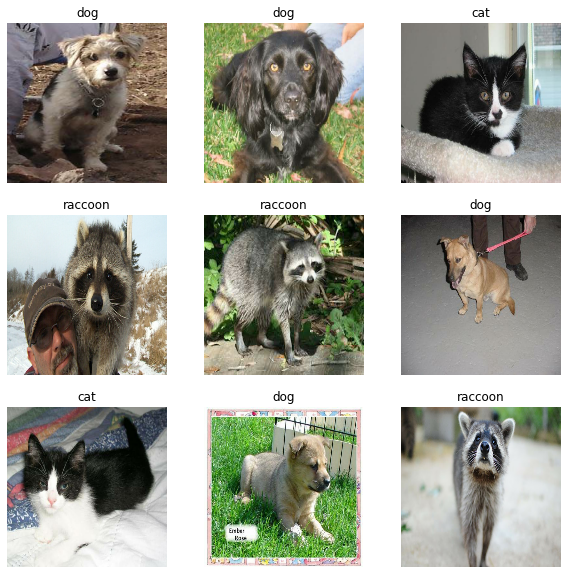

In [12]:
class_names=train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
val_baches=tf.data.experimental.cardinality(validation_dataset)
test_dataset=validation_dataset.take(val_baches // 5)
validation_dataset=validation_dataset.skip(val_baches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 30
Number of test batches: 7


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [16]:
#Aumento de datos
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.RandomFlip('horizontal'),
                    tf.keras.layers.RandomRotation(0.2),                     
])

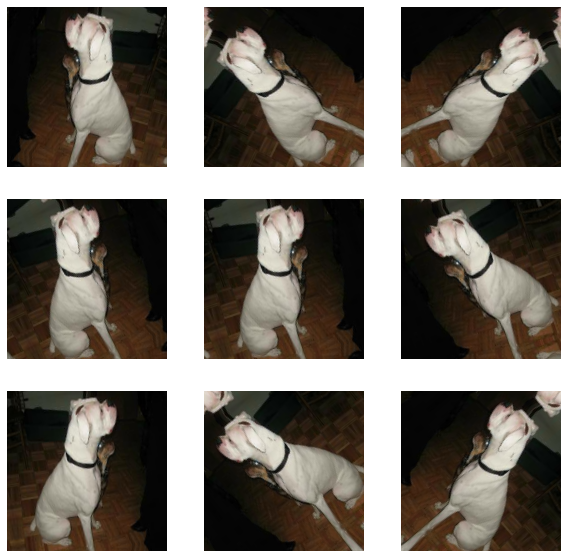

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image=data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [18]:
#Cambiar escala pixeles

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [19]:
#Creacion del modelo
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [20]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [21]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [22]:
#Agregar encabezado de clasificacion
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
#Compilacion del modelo
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
len(model.trainable_variables)

2

In [27]:
#Training model
initial_epochs = 50
loss0, accuracy0 = model.evaluate(validation_dataset)

30/30 [==============================] - 5s 72ms/step - loss: 0.8520 - accuracy: 0.3646


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.36


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
21/21 [==============================] - 8s 201ms/step - loss: 0.8299 - accuracy: 0.2896 - val_loss: 0.7669 - val_accuracy: 0.3909
Epoch 2/50
21/21 [==============================] - 4s 180ms/step - loss: 0.5850 - accuracy: 0.3032 - val_loss: 0.7057 - val_accuracy: 0.4194
Epoch 3/50
21/21 [==============================] - 4s 181ms/step - loss: 0.3454 - accuracy: 0.3318 - val_loss: 0.6590 - val_accuracy: 0.4299
Epoch 4/50
21/21 [==============================] - 4s 180ms/step - loss: 0.2635 - accuracy: 0.3333 - val_loss: 0.6103 - val_accuracy: 0.4257
Epoch 5/50
21/21 [==============================] - 4s 181ms/step - loss: 0.0530 - accuracy: 0.3379 - val_loss: 0.5492 - val_accuracy: 0.4468
Epoch 6/50
21/21 [==============================] - 4s 182ms/step - loss: -0.0420 - accuracy: 0.3454 - val_loss: 0.5103 - val_accuracy: 0.4457
Epoch 7/50
21/21 [==============================] - 4s 181ms/step - loss: -0.1501 - accuracy: 0.3529 - val_loss: 0.4710 - val_accuracy: 0.4531
Epoc

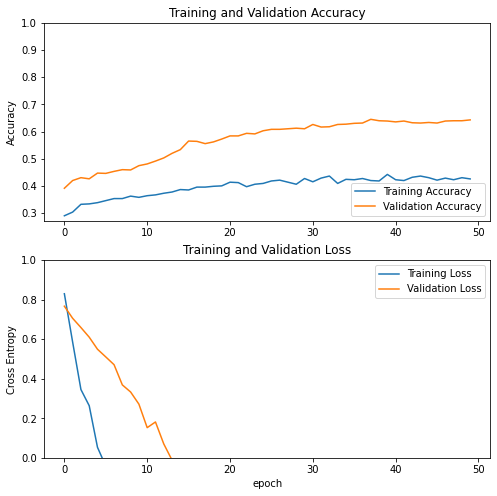

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
#Capas superiores modelo
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [32]:
#Compilacion modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [34]:
len(model.trainable_variables)

56

In [35]:
#Continuacion entrenamiento del modelo
fine_tune_epochs = 20
total_epochs = initial_epochs +fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 50/70
21/21 [==============================] - 13s 262ms/step - loss: -10.7453 - accuracy: 0.4404 - val_loss: -5.2540 - val_accuracy: 0.5058
Epoch 51/70
21/21 [==============================] - 5s 204ms/step - loss: -22.2780 - accuracy: 0.4042 - val_loss: -10.5151 - val_accuracy: 0.5279
Epoch 52/70
21/21 [==============================] - 5s 202ms/step - loss: -32.4995 - accuracy: 0.4223 - val_loss: -14.2240 - val_accuracy: 0.6249
Epoch 53/70
21/21 [==============================] - 5s 200ms/step - loss: -42.2844 - accuracy: 0.4419 - val_loss: -15.7476 - val_accuracy: 0.5490
Epoch 54/70
21/21 [==============================] - 5s 200ms/step - loss: -47.8125 - accuracy: 0.4615 - val_loss: -20.5717 - val_accuracy: 0.6502
Epoch 55/70
21/21 [==============================] - 5s 202ms/step - loss: -53.6861 - accuracy: 0.4887 - val_loss: -24.3884 - val_accuracy: 0.6512
Epoch 56/70
21/21 [==============================] - 5s 205ms/step - loss: -57.8287 - accuracy: 0.5098 - val_loss: -24

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

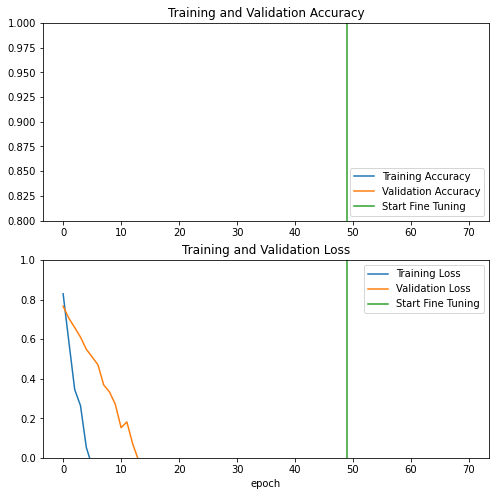

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
#Evaluacion y prediccion
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 1s 66ms/step - loss: -36.1419 - accuracy: 0.7723
Test accuracy : 0.7723214030265808


Predictions:
 [2 2 0 2 2 2 2 2 0 2 0 2 2 0 2 0 0 2 2 2 2 2 0 2 0 2 2 2 0 2 0 2]
Labals:
 [1 1 0 1 1 1 0 0 0 2 0 1 1 0 1 0 0 1 1 2 1 1 0 1 0 2 1 2 0 1 1 1]


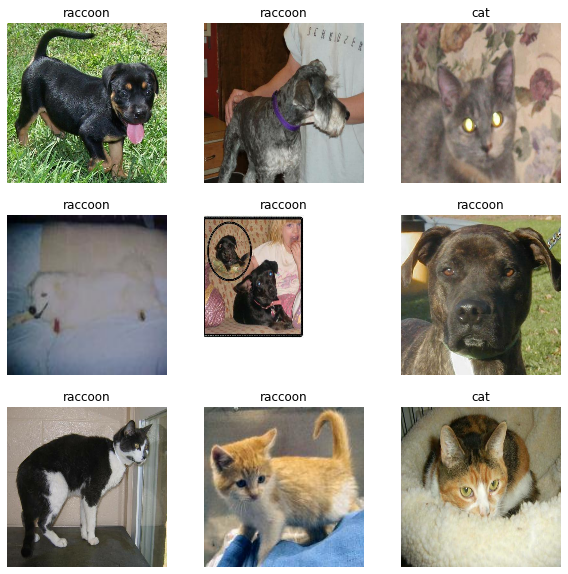

In [39]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 2)

print('Predictions:\n', predictions.numpy())
print('Labals:\n', label_batch)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")